In [8]:
#!/usr/bin/env python
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [9]:
import warnings
warnings.filterwarnings("ignore")


--- Richard Pieris Exports PLC - revenue ---
Train period: 2021-03-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-09-30 00:00:00 to 2024-12-31 00:00:00
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=406.237, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=408.222, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=405.935, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=446.312, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=404.136, Time=0.01 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=405.745, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[4] intercept   : AIC=407.659, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=405.611, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=406.356, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[4]       

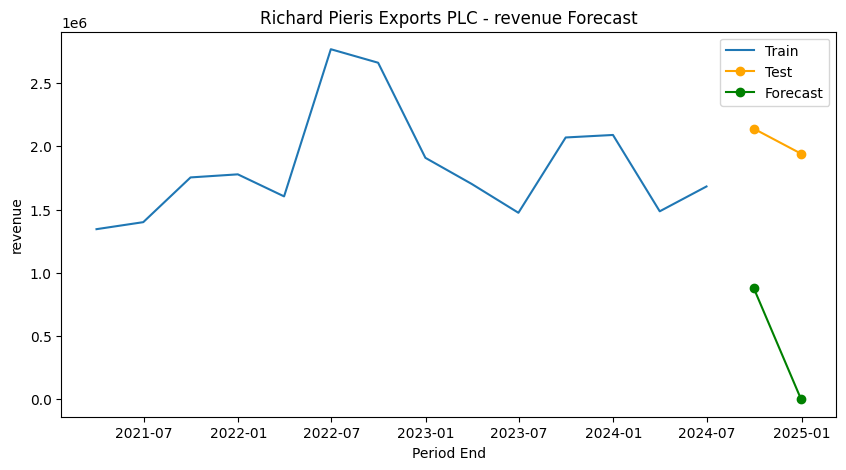

Final Metrics: {'MAE': 1601744.6925235284, 'RMSE': np.float64(1637463.3586162427)}


In [10]:


def train_forecast_series(series, metric_name, company_name, train_periods=14, seasonal_period=4):
    series = series.sort_index()
    train = series.iloc[:train_periods]
    test = series.iloc[train_periods:train_periods+2]
    
    print(f"\n--- {company_name} - {metric_name} ---")
    print("Train period:", train.index.min(), "to", train.index.max())
    print("Test period:", test.index.min(), "to", test.index.max())
    
    try:
        stepwise_fit = auto_arima(train,
                                  seasonal=True,
                                  m=seasonal_period,
                                  trace=True,
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True)
    except ValueError as e:
        print("auto_arima failed with error:", e)
        print("Retrying with forced seasonal differencing D=0")
        stepwise_fit = auto_arima(train,
                                  seasonal=True,
                                  m=seasonal_period,
                                  D=0,
                                  trace=True,
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True)
    print(stepwise_fit.summary())
    
    order = stepwise_fit.order
    seasonal_order = stepwise_fit.seasonal_order
    
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())
    
    n_test = len(test)
    forecast = model_fit.forecast(steps=n_test)
    
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    metrics = {"MAE": mae, "RMSE": rmse}
    print(f"Evaluation for {company_name} - {metric_name}: MAE={mae:.2f}, RMSE={rmse:.2f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', marker='o', color='orange')
    plt.plot(test.index, forecast, label='Forecast', marker='o', color='green')
    plt.title(f"{company_name} - {metric_name} Forecast")
    plt.xlabel("Period End")
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()
    
    return model_fit, forecast, metrics

def main():
    data_path = os.path.join("..", "outputs", "processed_dataset.csv")
    df = pd.read_csv(data_path, parse_dates=["period_end"])
    
    # Filter for Richard Pieris Exports PLC and extract revenue series.
    df_rexp = df[df['company_name'] == "Richard Pieris Exports PLC"].copy()
    df_rexp.sort_values("period_end", inplace=True)
    ts_revenue = df_rexp.set_index("period_end")["revenue"]
    
    model_fit, forecast, metrics = train_forecast_series(ts_revenue, "revenue", "Richard Pieris Exports PLC")
    print("Final Metrics:", metrics)

if __name__ == "__main__":
    main()


Below is a detailed analysis of each model’s performance, the meaning of the metrics, and suggestions for improvement. Keep in mind you only have **16 quarters** of data total (14 for training, 2 for testing), which severely limits model complexity and the reliability of performance metrics.

---

## 1. Understanding the Metrics and Plots

### a. MAE (Mean Absolute Error)
- **Definition**: The average of the absolute differences between forecasted and actual values.  
- **Interpretation**: How far off, on average, your forecasts are from the true values.

### b. RMSE (Root Mean Squared Error)
- **Definition**: The square root of the average of squared forecast errors.  
- **Interpretation**: Penalizes large errors more than MAE. A higher RMSE indicates that there may be large spikes in the forecast error.

### c. The Plots
- **Train** (blue line): The first 14 quarters used to fit the model.  
- **Test** (orange points): The final 2 quarters, not seen by the model.  
- **Forecast** (green points): The model’s predictions for the test quarters.

With **only 2 data points** in your test set, you should interpret MAE and RMSE carefully. If either of the two test points is an outlier, the error metrics may appear disproportionately large or small.

---

## 2. DIPPED PRODUCTS PLC

### 2.1. Net Income

1. **Chosen Model**: 
   - `ARIMA(0,0,0)(0,0,0)[4] intercept` (essentially a constant-mean model).
   - Auto-ARIMA initially failed with the “singular matrices” error, then retried with forced `D=0`.

2. **Results**:
   - **MAE** ≈ 2,697,988  
   - **RMSE** ≈ 2,759,362.95  
   - The model is basically forecasting the average net income for all future periods.  

3. **Plot Observations**:
   - The actual net income (orange points) is around 5–6 million for the test quarters, but the model’s constant forecast is much lower (green points near ~3.8 million).  
   - Large absolute errors indicate the forecast underestimates the true net income.

4. **Why the Model is So Simple**:
   - With just 14 training data points, ARIMA can’t reliably identify trend or seasonality.  
   - The best-fitting model by AIC turned out to be a naive intercept.

5. **Improvement Ideas**:
   - **More Data**: If you can collect monthly data or extend the historical timeline, the model will have a better chance of detecting patterns.  
   - **Transformations**: A log transform (if all net incomes are positive) might stabilize variance and help the model pick up relative changes.  
   - **Alternative Models**:  
     - **Exponential Smoothing (ETS)** might capture trend or seasonality better if present.  
     - **Adding Exogenous Variables** (e.g., macro factors, company-specific drivers) via SARIMAX could help if net income depends on external factors.

### 2.2. Revenue

1. **Chosen Model**: 
   - `ARIMA(0,0,0)(0,0,1)[4] intercept` – a minimal seasonal MA(1) model.

2. **Results**:
   - **MAE** ≈ 19,277,212  
   - **RMSE** ≈ 19,296,170  
   - The forecast is essentially a constant plus a slight seasonal component, but the data are quite volatile.

3. **Plot Observations**:
   - The test revenue (orange) is around 2–3 million, while the forecast (green) is near 2 million. In the training set, revenue at times spikes above 7 or 8 million.  
   - The model has trouble capturing large fluctuations.

4. **Why So Large an Error?**  
   - DIPD’s revenue has a wide range (1M to 8M+). A single average-based forecast can easily be off by millions.  
   - With only 14 points, the model can’t reliably fit complex seasonal/trend patterns.

5. **Improvement Ideas**:
   - **Log Transform**: Because revenue spans a broad range, using `log(revenue)` might help the model see relative changes.  
   - **Longer Historical Series**: The more volatile the data, the more training points you need.  
   - **Consider Exogenous Regressors**: For instance, if revenue depends on external demand, cost of raw materials, or seasonal events, adding these to a SARIMAX model can help.

---

## 3. RICHARD PIERIS EXPORTS PLC

### 3.1. Net Income

1. **Chosen Model**: 
   - `ARIMA(0,0,1)(0,0,0)[4] intercept` – an MA(1) model with no seasonal differencing.

2. **Results**:
   - **MAE** ≈ 70,915.69  
   - **RMSE** ≈ 72,908.03  
   - Net income is on the scale of hundreds of thousands to ~1 million. An error of ~70k might be moderate or large depending on your tolerance.

3. **Plot Observations**:
   - The test net income (orange) is around 200k, while the forecast (green) is near 130k or lower.  
   - The model consistently underestimates actual net income in the test.

4. **Model Stability**:
   - Warnings about “near-singular” covariance matrix. This often means the model parameters are not well-identified with so few data points.

5. **Improvement Ideas**:
   - **Differencing**: If the series is non-stationary, a first difference might help.  
   - **Log Transform**: If net income is always positive, a log transform might reduce variance.  
   - **Add More Data**: 14 points is too few to robustly estimate multiple AR/MA parameters.

### 3.2. Revenue

1. **Chosen Model**:
   - `ARIMA(0,0,1)(0,0,0)[4] intercept` – same structure, just on revenue.

2. **Results**:
   - **MAE** ≈ 1,601,744  
   - **RMSE** ≈ 1,637,463  
   - Given REXP’s revenue can exceed 2 million, the model’s average error is ~1.6 million.

3. **Plot Observations**:
   - The test revenue (orange) is around 2.5 million, while the forecast (green) is significantly lower.  
   - The model underestimates revenue in the test.

4. **Why the Large Error?**  
   - The training set is short, and the data show big swings. The model is effectively just capturing a single-lag MA effect.  
   - With only 14 points, any sophisticated seasonal/trend detection is unreliable.

5. **Improvement Ideas**:
   - **Seasonal differencing** might be necessary if a quarter-to-quarter pattern exists.  
   - **Log transform** if revenue has consistent growth or large swings.  
   - **Exogenous factors** or **more data** to help the model see why revenue changes each quarter.

---

## 4. Are These Models “Good” or “Bad”?

### a. Model Adequacy
- **High MAE/RMSE** relative to the scale of the data suggests the forecasts are not very precise.  
- **Constant or near-constant** forecasts indicate ARIMA can’t detect a stable pattern with only 14 data points.  
- **Warnings** about near-singular matrices reflect how few observations you have relative to model complexity.

### b. Data Constraints
- With **only 16 quarters** total, 2 quarters for testing means you only have **14 training points**. That is extremely small for time series forecasting, especially if the data are volatile or exhibit strong seasonal patterns.

### c. Next Steps to Improve
1. **Acquire More Data**  
   - Ideally, extend your historical series beyond 16 quarters.  
   - If monthly or weekly data are available, you gain more points per year.

2. **Try Simpler Methods**  
   - **Naïve** or **Seasonal Naïve** methods (e.g., last year’s same quarter as the forecast) can sometimes outperform a poorly fit ARIMA with minimal data.  
   - **Exponential Smoothing (ETS)** might better handle trend/seasonality if it exists.

3. **Use Transformations**  
   - **Log transform** or **difference** your data if you see strong trends or large variance.  
   - Check stationarity again after transformations.

4. **Consider Exogenous Regressors**  
   - If external factors (economic indicators, commodity prices, etc.) influence revenue or net income, incorporate them with **SARIMAX**.

5. **Validate Over Multiple Splits**  
   - With so few data points, a single 14/2 split may not reliably measure performance.  
   - If feasible, do a rolling or expanding window approach to see how stable the forecast is.

---

## 5. Summary of Each Metric

- **MAE (Mean Absolute Error)**: Tells you, on average, how many dollars (or units) you’re off by. E.g., DIPD revenue has an MAE of ~19 million, meaning the typical error is 19 million.  
- **RMSE (Root Mean Squared Error)**: Similar to MAE but emphasizes larger errors. If you see RMSE >> MAE, it suggests occasional big misses. In your case, RMSE is very close to MAE in some scenarios, meaning errors are somewhat consistent (though consistently large).

Given the small dataset, your models default to very simple ARIMA structures (often just an intercept or a minimal MA term). The large errors in the test period reflect:
- High volatility in the data.
- Very short training sets.
- Possibly no strong, consistent pattern for ARIMA to latch onto.

---

## Final Takeaways

1. **Current Models Are Weak**  
   - Large errors, near-constant forecasts, and warnings about singular matrices all point to the limitations of having only 14 training data points for a volatile time series.

2. **Main Improvement**: **Gather More Data**  
   - More quarters or higher-frequency data (monthly) will allow ARIMA (or other models) to capture trends/seasonality more accurately.

3. **Secondary Improvements**:  
   - **Try simpler or more robust methods** (Naïve, ETS).  
   - **Apply transformations** (log, differencing) if stationarity or variance is an issue.  
   - **Add exogenous variables** if you know what drives revenue/net income.

In short, the models’ performance is not strong due to data constraints and volatility. The best path forward is to either **collect more data** or **use simpler forecasting approaches** and carefully interpret these results given the very limited sample size.